# **Initialization**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import copy

!pip install optuna
import optuna

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, Flatten, Input, Layer, InputSpec, Lambda, Concatenate
from keras.initializers import glorot_uniform, ones, zeros
import keras.backend as K

!git clone https://github.com/ThiesCalje/Survival-Analysis-Deep-Learning-AML-.git
import os
os.chdir('/content/Survival-Analysis-Deep-Learning-AML-/Data')

     |████████████████████████████████| 308 kB 5.4 MB/s 
     |████████████████████████████████| 80 kB 5.1 MB/s 
     |████████████████████████████████| 209 kB 25.6 MB/s 
     |████████████████████████████████| 75 kB 2.4 MB/s 
     |████████████████████████████████| 144 kB 31.3 MB/s 
     |████████████████████████████████| 112 kB 37.1 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=f38ae687b4928f37c6f7bc20728e355b763bd6bf8a722b33a6677be47db83757
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Cloning into 'Survival-Analysis-Deep-Learning-AML-'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 155 (delta 38), reused 128 (delta 26), pack-reused 0
Receiving objects: 100% (155/155), 4.70 MiB | 19

# **Data**

In [2]:
patient_data = pd.read_excel("Table 10.xlsx").sort_index()
gene_expression_df = pd.read_excel("Data_10_genex.xlsx").T.sort_index().iloc[:-2,:]
models = []
scaler = MinMaxScaler()
gene_expression = tf.convert_to_tensor(scaler.fit_transform(gene_expression_df).astype("float32"))
gene_expression

<tf.Tensor: shape=(435, 381), dtype=float32, numpy=
array([[5.0966179e-01, 2.4935303e-02, 1.6365096e-01, ..., 4.3937725e-01,
        4.3279311e-01, 8.5017793e-02],
       [6.3194695e-04, 5.7219350e-01, 2.4940684e-02, ..., 7.3147607e-01,
        3.8628918e-01, 1.7305648e-01],
       [2.3502643e-01, 4.6140003e-01, 4.9148807e-01, ..., 6.3994795e-01,
        1.2818909e-01, 5.7004178e-01],
       ...,
       [6.4831817e-01, 6.8367803e-01, 2.4224188e-02, ..., 2.7959046e-01,
        2.1255255e-01, 2.3446196e-01],
       [8.5588865e-04, 6.2505525e-01, 2.9509917e-01, ..., 8.2036322e-01,
        3.2042933e-01, 2.1075754e-01],
       [3.5630181e-01, 4.2814267e-01, 2.4681840e-02, ..., 8.6880779e-01,
        5.1177657e-01, 8.4859326e-02]], dtype=float32)>

# **Auxiliary functions**

In [3]:
def plot(history,size):

    fig = plt.figure(figsize=(size*2,size))

    plt.subplot(1,2,1)
    x_axis = np.arange(1, len(history.history['loss'])+1)
    plt.plot(x_axis, history.history['loss'], label='training')
    plt.plot(x_axis, history.history['val_loss'], label='validation')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # plt.subplot(1,2,2)
    # x_axis = np.arange(1, len(history.history['accuracy'])+1)
    # plt.plot(x_axis, history.history['accuracy'], label='training')
    # plt.plot(x_axis, history.history['val_accuracy'], label='validation')
    # plt.title('Training and validation accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend(loc='lower right')

    return fig

In [231]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        print(" This is the best trial so far")
        #study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
        study.set_user_attr(key="train_loss", value=trial.user_attrs["train_loss"])
        study.set_user_attr(key="test_loss", value=trial.user_attrs["test_loss"])

In [5]:
def classification(index, L):
    classifiction = list(np.zeros(L-1))
    classifiction.insert(index, 1)
    return classifiction

In [6]:
def Heatmap_Clustering(soft_labels, patient_data, var_of_interest):

    num_clusters        = len(soft_labels[0][:])
    clusters            = ["c{}".format(i+1) for i in range(num_clusters)]
    soft_labels         = pd.DataFrame(soft_labels.numpy(), columns = clusters)
    patient_data_cat    = pd.DataFrame(patient_data[var_of_interest])
    soft_labels_cat     = patient_data_cat.join(soft_labels)
    patient_labels      = np.unique(patient_data_cat)
    num_categories      = len(patient_labels)

    heatmap_data = pd.DataFrame(index = patient_labels, columns = clusters, dtype= "float32")
    # heatmap_data    = np.empty(shape=(num_categories, num_clusters))

    for i, entity in enumerate(patient_labels):

        cluster                     = soft_labels_cat[soft_labels_cat[var_of_interest]==entity]
        del cluster[var_of_interest]

        num_patients                = len(cluster)
        average_label_assignment    = np.sum(cluster, axis = 0) / num_patients
        heatmap_data.loc[entity]    = average_label_assignment
    
    heatmap_figure      = plt.figure(figsize=(15,12))
    heatmap             = sns.heatmap(heatmap_data, annot= True, fmt= ".4f")

In [7]:
def tSNE_plot(coords, var_of_interest):
    
    tsne = TSNE(2, perplexity = 20, verbose=1, random_state = 69)
    tsne_coordinates = tsne.fit_transform(coords)

    patientdat = patient_data[var_of_interest]
    labels = patientdat.astype('category').cat.codes.to_list()
    num_colors = len(np.unique(labels))
    colors = plt.get_cmap('rainbow', num_colors)

    fig_tsne = plt.figure(figsize= (10,10))
    plt.scatter(tsne_coordinates[:,0], tsne_coordinates[:,1], c= colors(labels))
    plt.legend()

In [277]:
def vis_dif(input, output):
    difference = abs(input - output).numpy()
    difference = difference.reshape(input.shape[0]*input.shape[1])
    # difference[difference > 1] = 1
    figure     = plt.figure(figsize=(15,12))
    plt.subplot(1,2,1)
    plt.boxplot(difference, showmeans = True)
    plt.subplot(1,2,2)
    plt.hist(difference, bins = 35)

In [9]:
def normalize(X):
    X = X/K.max(K.abs(X),axis=0)
    return X

In [131]:
def plot_VAE(train_loss, test_loss):

    fig = plt.figure(figsize=(10,10))

    # plt.subplot(3,1,1)
    # plt.plot(train_loss[:,0], label = 'train loss')
    # plt.plot(test_loss[:,0], label = 'test loss')
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.legend()

    colors = plt.get_cmap('plasma', 4)

    total_loss      = plt.gca()
    AE_loss         = total_loss.twinx()

    AE_train,       = AE_loss.plot(train_loss[:,2], label = 'train loss (auto-encoder)', color = "#17becf")
    AE_test,        = AE_loss.plot(test_loss[:,2], label = 'test loss (auto-encoder)', color = "#ff7f0e")
    AE_loss.set_ylabel("AE loss")

    total_train,    = total_loss.plot(train_loss[:,0], label = 'train loss (total)', color = "#1f77b4")
    total_test,     = total_loss.plot(test_loss[:,0], label = 'test loss (total)', color = "#d62728")
    total_loss.set_xlabel("Epochs")
    total_loss.set_ylabel("Total loss")
    # total_loss.grid(True)

    curves          = [AE_train, AE_test, total_train, total_test]
    total_loss.legend(curves, [curve.get_label() for curve in curves])

    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")

    # plt.subplot(3,1,2)
    # plt.plot(train_loss[:,1], label = 'train loss (KL)')
    # plt.plot(test_loss[:,1], label = 'test loss (KL)')
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.legend()

    # plt.subplot(3,1,3)
    # plt.plot(train_loss[:,2], label = 'train loss (auto-encoder)')
    # plt.plot(test_loss[:,2], label = 'test loss (auto-encoder)')
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.legend()

# **VAE**

## Building VAE

In [328]:
def sampling(args):
    z_mean, z_log_sigma = args
    latent_dim = K.shape(z_mean)
    epsilon = K.random_normal(shape=(latent_dim[0], latent_dim[1]),
                              mean=0., stddev=1)
    return z_mean + z_log_sigma * epsilon

In [267]:
def VAE(input_dim, structure):

    # K.clear_session()
    # test            = tf.keras.activations.relu(threshold=0.00001)

    hidden_layers_e = structure["hidden layers"]
    hidden_layers_d = hidden_layers_e[::-1]
    latent_dim      = structure["latent dimension size"]
    activation      = structure["activation"]
    drop            = structure["dropout rate"]

    input_e         = Input(shape   = (input_dim,), 
                            name    = "Input")
    input_d         = Input(shape   = (latent_dim,), 
                            name    = "Input")
    
    coder_length    = len(hidden_layers_e)
    names_e         = ["Encoding_layer_"]*coder_length
    names_d         = ["Decoding_layer_"]*coder_length


    hidden_layer_e  = Dense(hidden_layers_e[0],
                            kernel_initializer  = glorot_uniform(),
                            activation          = activation,
                            name                = "{}{}".format(names_e[0], 1))(input_e)
    hidden_layer_d  = Dense(hidden_layers_d[0],
                            kernel_initializer  = glorot_uniform(),
                            activation          = activation,
                            name                = "{}{}".format(names_d[0], 1))(input_d)


    hidden_layers_e.pop(0)
    hidden_layers_d.pop(0)

    for i in range(len(hidden_layers_e)):
        hidden_layer_e    = Dense(hidden_layers_e[i],
                                kernel_initializer  = glorot_uniform(),
                                activation          = activation,
                                name                = "{}{}".format(names_e[i], i+2))(hidden_layer_e)
        hidden_layer_d    = Dense(hidden_layers_d[i],
                                kernel_initializer  = glorot_uniform(),
                                activation          = activation,
                                name                = "{}{}".format(names_d[i], i+2))(hidden_layer_d)
    
    mean    = Dense(latent_dim,
                    kernel_initializer  = glorot_uniform(),
                    activation          = None,
                    name                = "z_mean")(hidden_layer_e)
    sigma   = Dense(latent_dim,
                    kernel_initializer  = glorot_uniform(),
                    activation          = non_zero,
                    name                = "z_sigma")(hidden_layer_e)
    # sigma_a = Activation(Lambda(lambda x: tf.keras.activations.relu(x, threshold=5)))(sigma)               
    z       = Lambda(sampling, name = "Sampling")([mean, sigma])

    output  = Dense(input_dim,
                    kernel_initializer  = glorot_uniform(),
                    activation          = activation,
                    name                = "Output")(hidden_layer_d)     

    # K.clear_session()  
    encoder     = Model(inputs  = input_e, 
                        outputs = [mean, sigma, z], 
                        name    = "VAE-encoder")
    decoder     = Model(inputs  = input_d, 
                        outputs = output, 
                        name    = "VAE-decoder")
    
    inputs      = Input(shape   = (input_dim,), 
                        name    = "Input")
    outputs     = decoder(encoder(input_e)[-1])
    autoencoder = keras.Model(inputs    = input_e, 
                      outputs   = outputs, 
                      name      = "VAE")
    # K.clear_session()  
    return encoder, decoder, autoencoder

## Training functions

### Training loop

In [209]:
def training_VAE(model, epochs, optimizer, trial, data = gene_expression):

    @tf.function 
    def trainstep(model, x_train, optimizer, encoder, mse):

        with tf.GradientTape() as tape:

            autoencoding        = model(x_train, training = True)
            # print('ae =',autoencoding)
            ae_loss             = mse(x_train, autoencoding)
            # print('ae loss =',ae_loss)

            # encoder             = Model(inputs  = autoencoder.input,
            #                                 outputs = autoencoder.get_layer("VAE-encoder").output)
            distribution        = encoder(x_train)[:2]
            # print('distri =',distribution)
            mean                = distribution[0]
            sigma               = distribution[1]
            num_patients, dim   = mean.shape

            kl_loss               = K.sum(-0.5 - K.log(sigma) + 0.5*K.square(mean) + 0.5*K.square(sigma))
            # print('kl loss =', kl_loss)
            loss                = ae_loss + kl_loss

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        return [loss, kl_loss, ae_loss]

    @tf.function
    def teststep(model, x_test, optimizer, encoder, mse):

        autoencoding        = model(x_test, training = False)
        # print('ae =',autoencoding)
        ae_loss             = mse(x_test, autoencoding)
        # print('ae loss =',ae_loss)

        # encoder             = Model(inputs  = autoencoder.input,
        #                                     outputs = autoencoder.get_layer("VAE-encoder").output)
        distribution        = encoder(x_test)[:2]
        #print('distri =',distribution)
        mean                = distribution[0]
        sigma               = distribution[1]
        num_patients, dim   = mean.shape

        kl_loss               = K.sum(-0.5 - K.log(sigma) + 0.5*K.square(mean) + 0.5*K.square(sigma))

        loss                = ae_loss + kl_loss

        return [loss, kl_loss, ae_loss]
    # print(data)
    input_dim       = data.shape[1]

    data    = pd.DataFrame(data.numpy())
    # data    = pd.DataFrame(normalize(data).numpy())

    num_patients    = data.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = tf.convert_to_tensor(data.iloc[ind_shuffle][:train_size])
    x_test      = tf.convert_to_tensor(data.iloc[ind_shuffle][train_size:])

    # gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    optimizer = keras.optimizers.Adam(learning_rate= 0.00001, clipnorm = 1)
    mse       = keras.losses.MeanSquaredError()
    # x_train = tf.convert_to_tensor(x_train)
    loss_train  = np.empty(shape=(epochs,3))
    loss_test   = np.empty(shape=(epochs,3))

    encoder         = Model(inputs  = model.input,
                            outputs = model.get_layer("VAE-encoder").output)

    for i in range(epochs):


        train_loss      = trainstep(model, x_train, optimizer, encoder, mse)
        loss_train[i]   = train_loss
        test_loss       = teststep(model, x_test, optimizer, encoder, mse)
        loss_test[i]    = test_loss

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    trial.set_user_attr(key="train_loss", value = loss_train)
    trial.set_user_attr(key="test_loss", value = loss_test)

    return model, loss_train, loss_test

### Activation functions

In [14]:
def arcsinh(x):
    return K.log(x + K.pow(K.square(x)+1, 0.5))

In [15]:
def non_zero(x):
    x = arcsinh(x)
    return K.abs(x) + 0.000001

## Training

In [326]:
def hyperpar_tuner_VAE(trial):

    K.clear_session()

    global gene_expression, models

    input_dim = gene_expression.shape[1]

    N_layers        = trial.suggest_int("N_layers", 1, 5)
    latent_dim      = 2 #trial.suggest_int("latent dimension size", 2, 15)
    activation      = trial.suggest_categorical("activation", ["relu", "selu"])
    optimizer       = trial.suggest_categorical("optimizer", ["adam", "SGD"])
    dropout_rate    = trial.suggest_float("dropout rate", 0, 0.4)
    learning_rate   = trial.suggest_float("learning rate", 10**-5, 10**-2)
    momentum        = trial.suggest_float("momentum", 0, 0.999)

    tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = momentum, clipnorm = 1)
    tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = momentum, clipnorm = 1)

    hidden_layers = []
    for i in range(N_layers):

        hlayer  = trial.suggest_int("hlay {}".format(i+1), 10, 2000)
        hidden_layers.append(hlayer)

    structure = {"hidden layers"          :   hidden_layers,
                 "latent dimension size"  :   latent_dim,
                 "activation"             :   activation,
                 "dropout rate"           :   dropout_rate}
    encoder, decoder, autoencoder       = VAE(input_dim, structure)
    autoencoder.build(input_shape=(None,input_dim))
    # autoencoder.summary()
    autoencoder, train_loss, test_loss  = training_VAE(autoencoder, 500, optimizer, trial)
    models.append(autoencoder)
    result                              = test_loss[-1, 0]
    # plot_VAE(train_loss, test_loss)

    return result


In [301]:
def find_VAE(n,d):

    global models, gene_expression
    models = []

    study = optuna.create_study(direction = "minimize", study_name = "Tuning VAE")
    study.optimize(hyperpar_tuner_VAE, n_trials=n, callbacks = [callback])

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")

    trial           = study.best_trial
    index           = trial.number
    autoencoder     = models[index]
    
    input_size      = len(autoencoder.get_weights()[-1])

    encoder_DEC     = Model(inputs  = autoencoder.input,
                            outputs = autoencoder.get_layer("VAE-encoder").output)


    # n_encoding_layers   = trial.params["N_layers"] 
    # encoding_layers     = autoencoder.layers[:n_encoding_layers*2+1]
    # encoder             = Sequential(encoding_layers) 

    
    kmeans = KMeans(n_clusters= d, n_init=20)
    kmeans.fit_predict(encoder_DEC.predict(gene_expression)[-1])
    clustering_layer  = ClusteringLayer(d, name = "cluster")(encoder_DEC.output[-1])
    encoder_DEC     = Model(inputs  = encoder_DEC.input,
                            outputs = clustering_layer)

    encoder_DEC.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    encoder_DEC.build(input_shape= (None,input_size))

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    return trial, autoencoder, encoder_DEC

[I 2021-11-04 16:48:04,179] A new study created in memory with name: Tuning VAE
[I 2021-11-04 16:48:14,572] Trial 0 finished with value: 2.5759410858154297 and parameters: {'N_layers': 2, 'activation': 'selu', 'optimizer': 'adam', 'dropout rate': 0.2630572393191921, 'learning rate': 0.0014104169049001653, 'momentum': 0.8827717895732595, 'hlay 1': 1730, 'hlay 2': 765}. Best is trial 0 with value: 2.5759410858154297.


 This is the best trial so far


[I 2021-11-04 16:48:25,073] Trial 1 finished with value: 0.575972318649292 and parameters: {'N_layers': 2, 'activation': 'relu', 'optimizer': 'adam', 'dropout rate': 0.08657456041375232, 'learning rate': 0.0045605717595956, 'momentum': 0.9123969970579889, 'hlay 1': 1519, 'hlay 2': 1095}. Best is trial 1 with value: 0.575972318649292.


 This is the best trial so far


[I 2021-11-04 16:48:39,810] Trial 2 finished with value: 0.39503365755081177 and parameters: {'N_layers': 4, 'activation': 'relu', 'optimizer': 'SGD', 'dropout rate': 0.35914997760693085, 'learning rate': 0.001461440691333374, 'momentum': 0.26651419781694086, 'hlay 1': 1194, 'hlay 2': 1177, 'hlay 3': 1062, 'hlay 4': 260}. Best is trial 2 with value: 0.39503365755081177.


 This is the best trial so far


[I 2021-11-04 16:48:48,854] Trial 3 finished with value: 0.3309202790260315 and parameters: {'N_layers': 3, 'activation': 'selu', 'optimizer': 'SGD', 'dropout rate': 0.2161635072160233, 'learning rate': 0.007348308107843858, 'momentum': 0.08798103420727811, 'hlay 1': 62, 'hlay 2': 1780, 'hlay 3': 512}. Best is trial 3 with value: 0.3309202790260315.


 This is the best trial so far


[I 2021-11-04 16:48:54,713] Trial 4 finished with value: 0.7997242212295532 and parameters: {'N_layers': 1, 'activation': 'relu', 'optimizer': 'SGD', 'dropout rate': 0.21370708595130583, 'learning rate': 0.009362662016668705, 'momentum': 0.42796650539226966, 'hlay 1': 1446}. Best is trial 3 with value: 0.3309202790260315.
[I 2021-11-04 16:49:00,148] Trial 5 finished with value: 0.6821116805076599 and parameters: {'N_layers': 2, 'activation': 'relu', 'optimizer': 'SGD', 'dropout rate': 0.15365818705718726, 'learning rate': 0.003989000777134157, 'momentum': 0.13805372921854736, 'hlay 1': 282, 'hlay 2': 694}. Best is trial 3 with value: 0.3309202790260315.
[I 2021-11-04 16:49:03,796] Trial 6 finished with value: 31.762197494506836 and parameters: {'N_layers': 1, 'activation': 'selu', 'optimizer': 'SGD', 'dropout rate': 0.2618069080928652, 'learning rate': 0.003707684794972737, 'momentum': 0.8792499877330716, 'hlay 1': 81}. Best is trial 3 with value: 0.3309202790260315.
[I 2021-11-04 16:4

 This is the best trial so far


[I 2021-11-04 16:49:20,860] Trial 8 finished with value: 21.456518173217773 and parameters: {'N_layers': 1, 'activation': 'relu', 'optimizer': 'SGD', 'dropout rate': 0.156005608421146, 'learning rate': 0.0078324270179078, 'momentum': 0.5014850934317916, 'hlay 1': 590}. Best is trial 7 with value: 0.17878425121307373.
[I 2021-11-04 16:49:32,997] Trial 9 finished with value: 1.4060734510421753 and parameters: {'N_layers': 2, 'activation': 'selu', 'optimizer': 'adam', 'dropout rate': 0.3706261718294664, 'learning rate': 0.0025371235165759236, 'momentum': 0.9615376285420248, 'hlay 1': 1572, 'hlay 2': 1499}. Best is trial 7 with value: 0.17878425121307373.
[I 2021-11-04 16:49:46,235] Trial 10 finished with value: 0.08477851003408432 and parameters: {'N_layers': 5, 'activation': 'selu', 'optimizer': 'adam', 'dropout rate': 0.014700013368813571, 'learning rate': 7.651929976385582e-05, 'momentum': 0.6307541177798561, 'hlay 1': 1004, 'hlay 2': 24, 'hlay 3': 31, 'hlay 4': 1455, 'hlay 5': 1019}. 

 This is the best trial so far


[I 2021-11-04 16:49:59,718] Trial 11 finished with value: 0.15681052207946777 and parameters: {'N_layers': 5, 'activation': 'selu', 'optimizer': 'adam', 'dropout rate': 0.013532167773058972, 'learning rate': 0.0003363287118074527, 'momentum': 0.6338623820748659, 'hlay 1': 853, 'hlay 2': 60, 'hlay 3': 54, 'hlay 4': 1619, 'hlay 5': 992}. Best is trial 10 with value: 0.08477851003408432.
[I 2021-11-04 16:50:13,816] Trial 12 finished with value: 0.21997976303100586 and parameters: {'N_layers': 5, 'activation': 'selu', 'optimizer': 'adam', 'dropout rate': 0.007896979307425524, 'learning rate': 0.0005929053828279494, 'momentum': 0.6654152051794526, 'hlay 1': 836, 'hlay 2': 39, 'hlay 3': 43, 'hlay 4': 1781, 'hlay 5': 961}. Best is trial 10 with value: 0.08477851003408432.
[I 2021-11-04 16:50:32,169] Trial 13 finished with value: 1.3688467741012573 and parameters: {'N_layers': 4, 'activation': 'selu', 'optimizer': 'adam', 'dropout rate': 0.07674949265912182, 'learning rate': 0.0004423424118500

Number of finished trials: 15
Best trial:
  Value: 0.08477851003408432
  Params: 
    N_layers: 5
    activation: selu
    optimizer: adam
    dropout rate: 0.014700013368813571
    learning rate: 7.651929976385582e-05
    momentum: 0.6307541177798561
    hlay 1: 1004
    hlay 2: 24
    hlay 3: 31
    hlay 4: 1455
    hlay 5: 1019


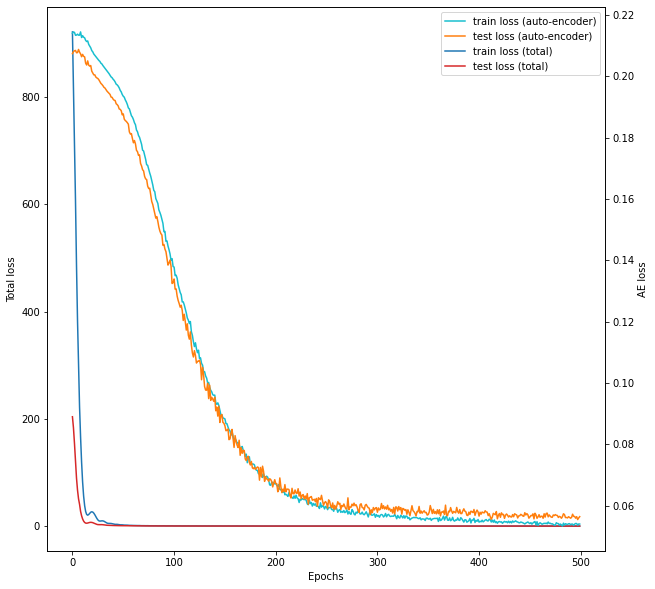

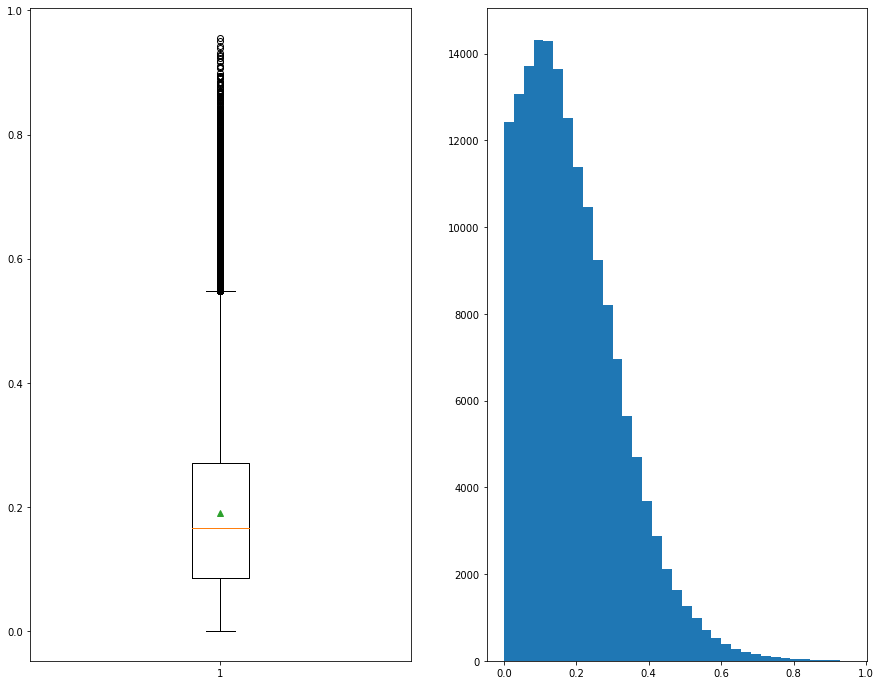

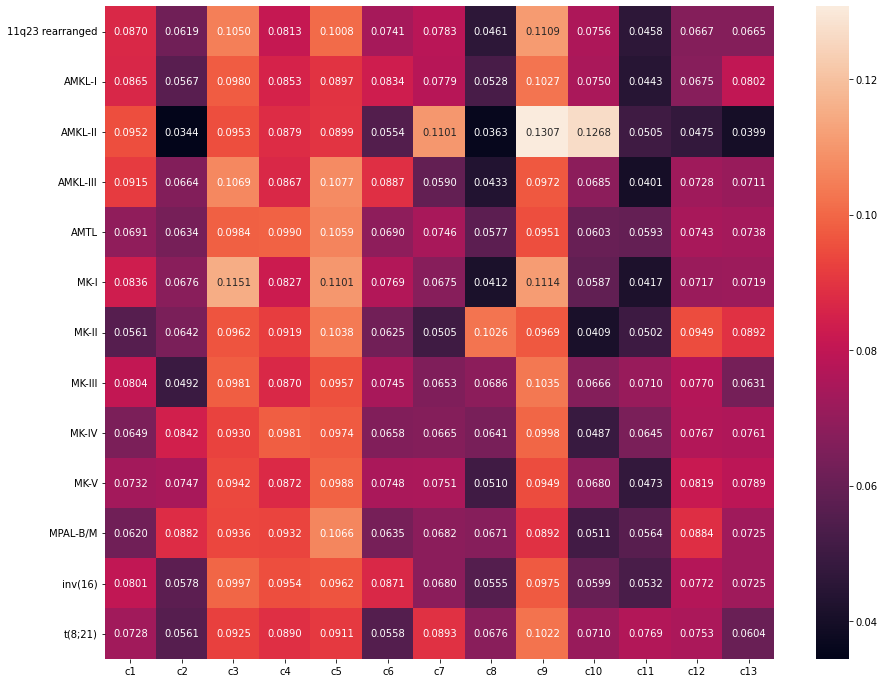

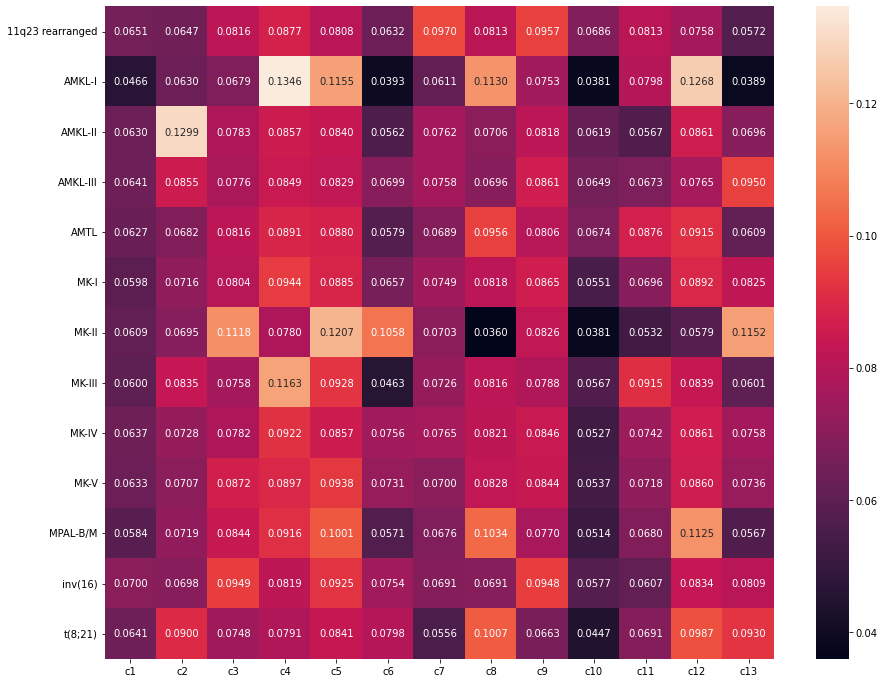

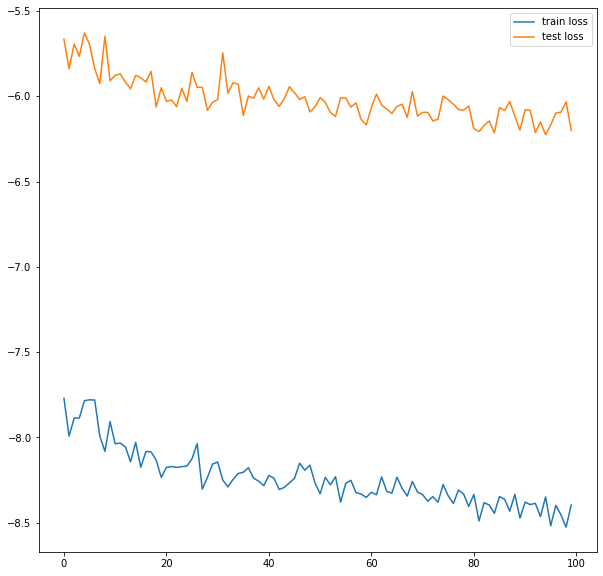

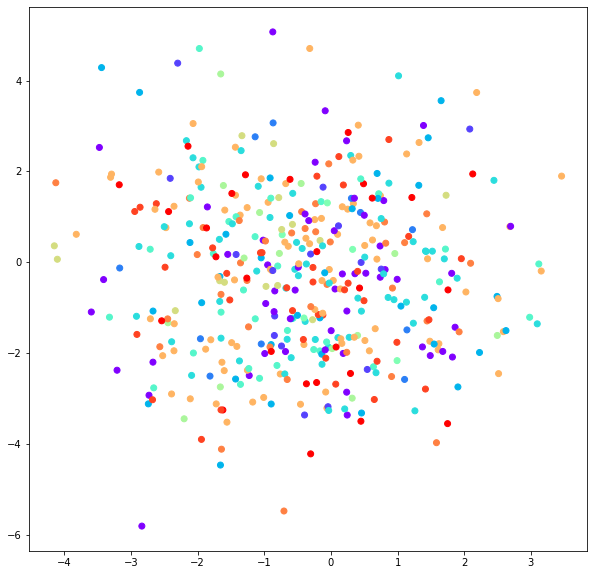

In [329]:
experiment, vae, encoder_dec = find_VAE(15,13)
test_loss = experiment.user_attrs["test_loss"]
train_loss= experiment.user_attrs["train_loss"]
plot_VAE(train_loss, test_loss)
output = vae(gene_expression)
vis_dif(gene_expression, output)
var_of_interest = "Transcriptional_Identity"
results         = encoder_dec(gene_expression)
Heatmap_Clustering(results, patient_data, var_of_interest)

# input_size  = gene_expression.shape[1]
# encoder_2   = tf.keras.models.clone_model(encoder_dec)
# encoder_2.build(input_shape = (None, input_size))
# encoder_2.set_weights(encoder_cluster.get_weights())
# encoder_2.summary()

encoder_dec, train_loss, test_loss    = training(encoder_dec, 100)

results         = encoder_dec(gene_expression)
Heatmap_Clustering(results, patient_data, var_of_interest)

fig = plt.figure(figsize=(10,10))
plt.plot(train_loss, label = 'train loss')
plt.plot(test_loss, label = 'test loss')
plt.legend()

patientdat = patient_data[var_of_interest]
labels = patientdat.astype('category').cat.codes.to_list()
num_colors = len(np.unique(labels))
colors = plt.get_cmap('rainbow', num_colors)

encoder  = Model(inputs  = encoder_dec.input,
                outputs = encoder_dec.get_layer("Sampling").output)
# encoder.summary()
coords = encoder(gene_expression)
fig = plt.figure(figsize=(10,10))
plt.scatter(coords[:,0],coords[:,1], c= colors(labels))

# **Auto-encoding**

In [ ]:
def Auto_encoder(input_size, structure):
    
    hidden_layers   = structure['hidden layers']
    embedding_size  = structure['embedding layer']
    activation      = structure['activation']
    drop            = structure["dropout rate"]

    structure       = hidden_layers + [embedding_size] + hidden_layers[::-1]
    
    coder_length    = len(hidden_layers)

    model           = Sequential(name = "Auto-encoder")

    model.add(Input(shape   = (input_size,), 
                    name    = "Input"))
    
    names           = ["Encoding_layer-"]*coder_length + ["Embedding_layer"] + ["Decoding_layer-"]*coder_length
    numbers         = np.concatenate((np.array(range(coder_length)) + 1, np.array(range(coder_length))+1)).tolist()

    numbers.insert(coder_length, "")

    for i,j in enumerate(structure):
        model.add(Dense(j,
                        kernel_initializer  = glorot_uniform(),
                        activation          = activation,
                        name                = "{}{}".format(names[i],numbers[i]))
        )
        model.add(Dropout(drop,
                          name = "Dropout-{}".format(i+1)))
    
    model.add(Dense(input_size,
                    kernel_initializer  = glorot_uniform(),
                    activation          = activation,
                    name                = "Output")
    )

    return model


In [ ]:
def par_tuner(trial):

    global gene_expression, models

    #gene_expression = pd.read_excel("Data_10_genex.xlsx").T.sort_index().iloc[:-2,:]
    # gene_expression = gene_expression.astype("float32")
    input_dim       = gene_expression.shape[1]

    scaler = MinMaxScaler()
    gene_expression = pd.DataFrame(scaler.fit_transform(gene_expression))

    num_patients    = gene_expression.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = gene_expression.iloc[ind_shuffle][:train_size]
    x_test      = gene_expression.iloc[ind_shuffle][train_size:]

    gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    N_layers        = trial.suggest_int("N_layers", 1, 5)
    embedding_layer = trial.suggest_int("embedding layer size", 10, 50)
    activation      = trial.suggest_categorical("activation", ["relu", "selu"])
    optimizer       = trial.suggest_categorical("optimizer", ["adam", "SGD"])
    dropout_rate    = trial.suggest_float("dropout rate", 0, 0.4)
    learning_rate   = trial.suggest_float("learning rate", 10**-4, 1)
    momentum        = trial.suggest_float("momentum", 0, 0.999)

    tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = momentum)
    tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = momentum)

    hidden_layers = []
    for i in range(N_layers):

        hlayer  = trial.suggest_int("hlay {}".format(i+1), 10, 2000)
        hidden_layers.append(hlayer)

    structure = {"hidden layers"    :   hidden_layers,
                 "embedding layer"  :   embedding_layer,
                 "activation"       :   activation,
                 "dropout rate"     :   dropout_rate}

    model = Auto_encoder(input_dim, structure)

    model.compile(loss      = "mse", 
                  optimizer = optimizer,
                  metrics   = ["accuracy"])

    history = model.fit(x_train, 
                        x_train,
                        epochs          = 100,
                        validation_data = (x_test,x_test),
                        verbose = False)
    
    global models
    models.append(model)

    loss, accuracy    = model.evaluate(x_test,x_test, verbose = False)

    # if trial.number == 0:
    #     trial.set_user_attr("Best model", model)
    # elif loss < trial.user_attrs[1]:
    #     trial.set_user_attr("Best model", model)
    # trial.set_user_attr(key="best_booster", value=model)
    # print(trial.user_attrs)
    plot(history,10)

    return loss

In [ ]:
def find_autoencoder(n,d):

    global models, gene_expression
    models = []

    study = optuna.create_study(direction = "minimize", study_name = "Tuning auto-encoder")
    study.optimize(par_tuner, n_trials=n, callbacks = [callback])

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")

    trial           = study.best_trial
    index           = trial.number
    autoencoder     = models[index]
    
    input_size      = len(autoencoder.get_weights()[-1])

    n_encoding_layers   = trial.params["N_layers"] 
    encoding_layers     = autoencoder.layers[:n_encoding_layers*2+1]
    encoder             = Sequential(encoding_layers) 

    
    kmeans = KMeans(n_clusters= d, n_init=20)
    kmeans.fit_predict(encoder.predict(gene_expression))
    encoder.add(ClusteringLayer(d, name = "cluster"))

    encoder.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    encoder.build(input_shape= (None,input_size))

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    return trial, autoencoder, encoder

# **Clustering**

## Clustering layer

In [292]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [293]:
def add_cluslayer(model, data, d):

    input_size  = data.shape[1]
    encoder_cluster   = tf.keras.models.clone_model(model)
    encoder_cluster.build(input_shape = (None, input_size))
    encoder_cluster.set_weights(model.get_weights())

    kmeans      = KMeans(n_clusters= d, n_init=20)
    kmeans.fit_predict(encoder_cluster.predict(data))
    encoder_cluster.add(ClusteringLayer(d, name = "cluster"))

    encoder_cluster.get_layer(name='cluster').set_weights([kmeans.cluster_centers_])

    #encoder_cluster.build(input_shape= (None,input_size))

    return encoder_cluster

## Training

In [309]:
def training(model, epochs, data = gene_expression):

    @tf.function(experimental_relax_shapes=True)
    def trainstep(model, x_train, optimizer):

        with tf.GradientTape() as tape:

            q       = model(x_train, training= True)
            p       = K.square(q) / K.sum(q, axis=0)
            p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
            loss    = K.sum(p*K.log(p/q))

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        return loss

    @tf.function(experimental_relax_shapes=True)
    def teststep(model, x_test, optimizer):

        q       = model(x_test, training= False)
        p       = K.square(q) / K.sum(q, axis=0)
        p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
        loss    = K.sum(p*K.log(p/q))

        return loss

    input_dim       = data.shape[1]

    scaler  = MinMaxScaler()
    data    = pd.DataFrame(scaler.fit_transform(data))

    num_patients    = data.shape[0]
    ind_shuffle     = random.sample(list(range(num_patients)), num_patients)
    train_size      = int(0.80*num_patients) 

    x_train     = data.iloc[ind_shuffle][:train_size]
    x_test      = data.iloc[ind_shuffle][train_size:]

    # gene_expression = tf.convert_to_tensor(gene_expression.astype("float32"))

    optimizer = keras.optimizers.SGD(learning_rate= 0.01)
    # x_train = tf.convert_to_tensor(x_train)
    loss_train  = []
    loss_test   = []

    for i in range(epochs):

        train_loss  = trainstep(model, x_train, optimizer)
        loss_train.append(train_loss)
        test_loss   = teststep(model, x_test, optimizer)
        loss_test.append(test_loss)

    return model, loss_train, loss_test


[I 2021-11-01 10:52:50,428] A new study created in memory with name: Tuning auto-encoder
[I 2021-11-01 10:54:04,007] Trial 0 finished with value: 0.02775384671986103 and parameters: {'N_layers': 2, 'embedding layer size': 39, 'activation': 'relu', 'optimizer': 'adam', 'dropout rate': 0.31385370439068566, 'learning rate': 0.046431943597199196, 'momentum': 0.7822388797257945, 'hlay 1': 1927, 'hlay 2': 1269}. Best is trial 0 with value: 0.02775384671986103.


 This is the best trial so far
Number of finished trials: 1
Best trial:
  Value: 0.02775384671986103
  Params: 
    N_layers: 2
    embedding layer size: 39
    activation: relu
    optimizer: adam
    dropout rate: 0.31385370439068566
    learning rate: 0.046431943597199196
    momentum: 0.7822388797257945
    hlay 1: 1927
    hlay 2: 1269


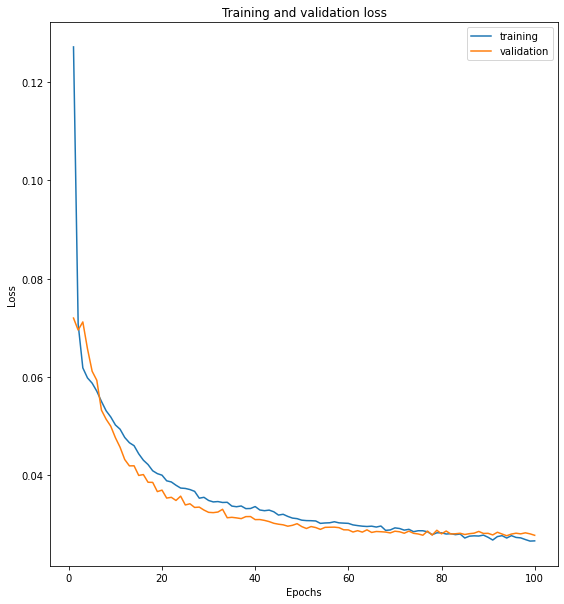

In [ ]:
var_of_interest     = "Transcriptional_Identity"
trial, autoencoder, encoder = find_autoencoder(1,10)
coords  = encoder(gene_expression, training = False)
# tSNE_plot(coords, var_of_interest)

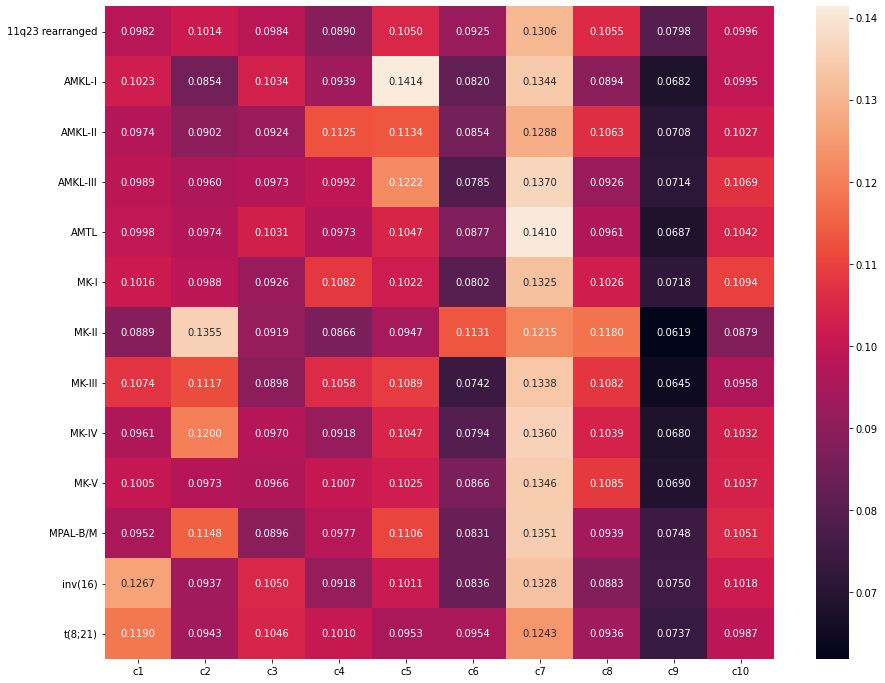

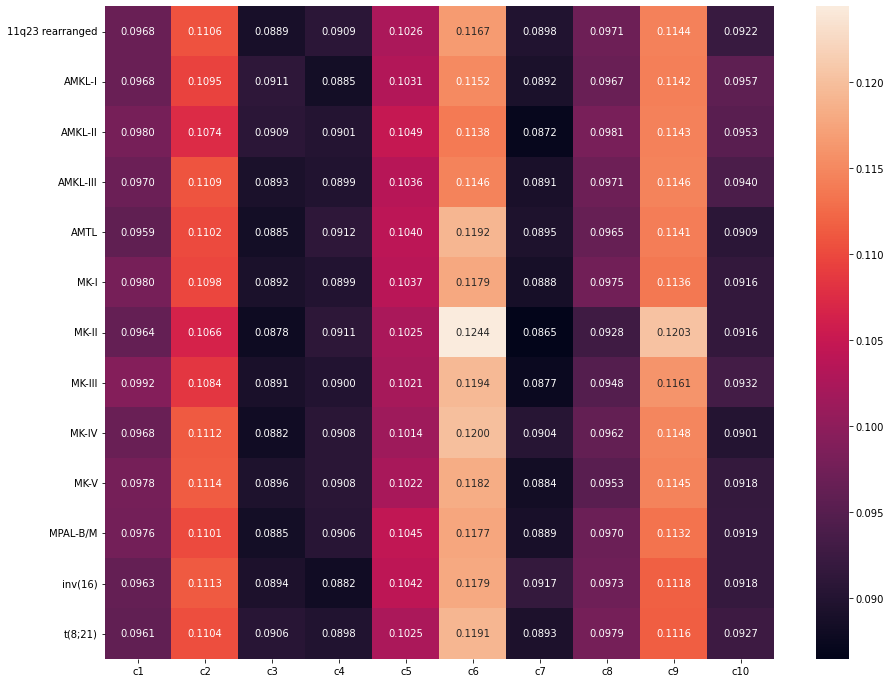

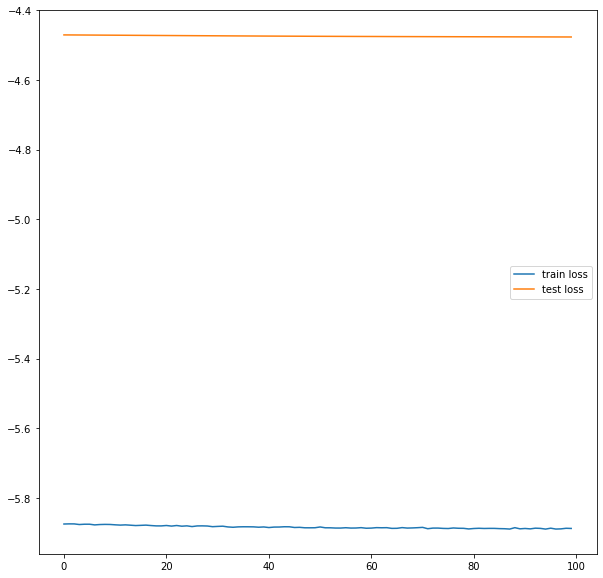

In [ ]:
# @tf.function(experimental_relax_shapes=True)
# def trainstep(model, x_train, optimizer):

#     with tf.GradientTape() as tape:

#         q       = model(x_train, training= True)
#         p       = K.square(q) / K.sum(q, axis=0)
#         p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
#         loss    = K.sum(p*K.log(p/q))

#     grads = tape.gradient(loss, model.trainable_weights)
#     optimizer.apply_gradients(zip(grads, model.trainable_weights))

#     return loss

# @tf.function(experimental_relax_shapes=True)
# def teststep(model, x_test, optimizer):

#     q       = model(x_test, training= False)
#     p       = K.square(q) / K.sum(q, axis=0)
#     p       = K.transpose( K.transpose(p) / K.sum(q, axis=1))
#     loss    = K.sum(p*K.log(p/q))

#     return loss

data        = gene_expression

# encoder_cluster     = add_cluslayer(encoder, data, 13)

var_of_interest = "Transcriptional_Identity"
results         = encoder(gene_expression)
Heatmap_Clustering(results, patient_data, var_of_interest)

input_size  = data.shape[1]
encoder_2   = tf.keras.models.clone_model(encoder)
encoder_2.build(input_shape = (None, input_size))
# encoder_2.set_weights(encoder_cluster.get_weights())
# encoder_2.summary()

encoder_2, train_loss, test_loss    = training(encoder_2, 100)

results         = encoder_2(gene_expression)
Heatmap_Clustering(results, patient_data, var_of_interest)

fig = plt.figure(figsize=(10,10))
plt.plot(train_loss, label = 'train loss')
plt.plot(test_loss, label = 'test loss')
plt.legend()